In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
!pip install mlxtend

  Using cached mlxtend-0.21.0-py2.py3-none-any.whl (1.3 MB)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions


from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import iris
from qiskit_machine_learning.algorithms import QSVC



In [5]:



iris = datasets.load_iris()




sepal_length = iris['data'][:, 0]
petal_length = iris['data'][:, 2]
X = np.column_stack((sepal_length, petal_length))
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(X, iris.target, test_size = 0.2, random_state=22)




#training_features, training_labels, test_features, test_labels = iris(
#    training_size=100, test_size=50, n=2, plot_data=True
#)


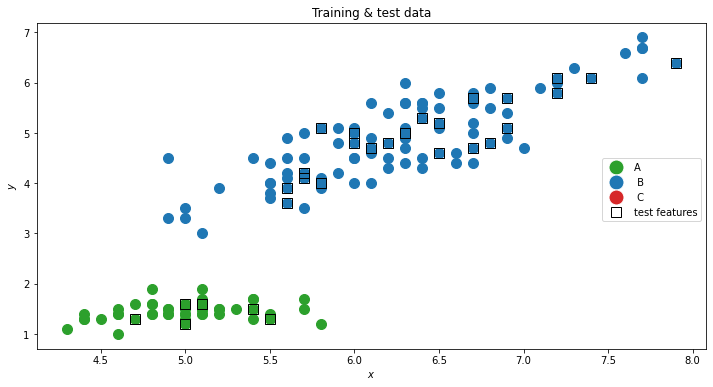

In [8]:
def plot_sampled_data():
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    import matplotlib.pyplot as plt

    plt.figure(figsize = (12,6))

    for feature, label in zip(X, y):
        marker = 'o' 
        if label.any() == 0 : 
            color = 'tab:green'
        elif label.any() == 1 :
            color = 'tab:blue' 
        elif label.any() == 2 :
            color = 'tab:red'
                
        plt.scatter(feature[0], feature[1], marker = marker, s = 100, color = color)
     
    for feature, label in zip(x_test, y_test):
        marker = 's' 
        plt.scatter(feature[0], feature[1], marker = marker, s = 100, facecolor = 'none', edgecolor = 'k')
    
    legend_elements = [
        Line2D([0], [0], marker ='o', c = 'w', mfc ='tab:green', label = 'A', ms = 15),
        Line2D([0], [0], marker ='o', c = 'w', mfc ='tab:blue', label =' B', ms = 15),
        Line2D([0], [0], marker ='o', c = 'w', mfc ='tab:red', label =' C', ms = 15),
        Line2D([0], [0], marker ='s', c = 'w', mfc ='none', mec='k', label='test features', ms=10)
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.6))
    
    plt.title('Training & test data')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    
plot_sampled_data()

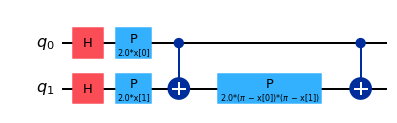

In [9]:
from qiskit.opflow import PauliExpectation, CircuitSampler
from qiskit.utils import QuantumInstance

backend = Aer.get_backend('statevector_simulator')
q_instance = QuantumInstance(backend, shots = 8192, seed_simulator = 2718, seed_transpiler = 2718)


dim = 2
feature_map = ZZFeatureMap(dim, reps=1, entanglement = 'linear').decompose()  # let's keep it simple!
feature_map.draw('mpl', style='iqx')

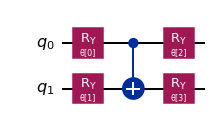

In [10]:
ansatz = RealAmplitudes(num_qubits=dim, entanglement='linear', reps=1).decompose()  # also simple here!
ansatz.draw('mpl', style='iqx')

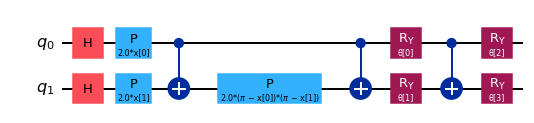

In [11]:
circuit = feature_map.compose(ansatz)
circuit.draw('mpl', style='iqx')

In [12]:
from qiskit.opflow import Z, I
hamiltonian = Z ^ Z  # global Z operators

In [13]:
from qiskit.opflow import StateFn

In [14]:
from qiskit.algorithms.optimizers import GradientDescent

gd_loss = []
def gd_callback(nfevs, x, fx, stepsize):
    gd_loss.append(fx)
    
gd = GradientDescent(maxiter=300, learning_rate=0.01, callback = gd_callback)

In [17]:


expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
in_pauli_basis = PauliExpectation().convert(expectation)
sampler = CircuitSampler(q_instance)

def evaluate_expectation(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(in_pauli_basis, params=value_dict).eval()  
    return np.real(result)

point = np.random.random(ansatz.num_parameters)
index = 2
eps = 0.2
e_i = np.identity(point.size)[:, index]  # identity vector with a 1 at index ``index``, otherwise 0

plus = point + eps * e_i
minus = point - eps * e_i




finite_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * eps)

print(finite_difference)

0.19063607814785402


In [18]:
initial_point = np.random.random(ansatz.num_parameters)

print(initial_point)

[0.35684775 0.24081818 0.07273266 0.66805221]


In [31]:


gd_in_pauli_basis = PauliExpectation().convert(gd)

def evaluate_gd(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(gd_in_pauli_basis, params = value_dict).eval()  # add parameters in here!
    return np.real(result)    

In [47]:
x_opt, fx_opt, nfevs = gd.minimize(fun = evaluate_expectation,  # function to evaluate the gradient 
                                   x0 = initial_point,          # initial point
                                   jac = evaluate_gd)  

Traceback (most recent call last):
  Input In [47] in <cell line: 1>
    x_opt, fx_opt, nfevs = gd.minimize(fun = evaluate_expectation,  # function to evaluate the gradient
  File /opt/conda/lib/python3.8/site-packages/qiskit/algorithms/optimizers/gradient_descent.py:180 in minimize
    update = jac(x)
  Input In [31] in evaluate_gd
    result = sampler.convert(gd_in_pauli_basis, params = value_dict).eval()  # add parameters in here!
  File /opt/conda/lib/python3.8/site-packages/qiskit/opflow/converters/circuit_sampler.py:166 in convert
    op_id = operator.instance_id
AttributeError: 'GradientDescent' object has no attribute 'instance_id'

Use %tb to get the full traceback.


In [36]:


qsvc_expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
C = 1
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(StandardScaler(), SVC( C = C, decision_function_shape='ovo'))
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, decision_function_shape='ovo'))])

In [39]:
model = clf.fit(X, y)
clf.score(x_test, y_test)

0.9333333333333333

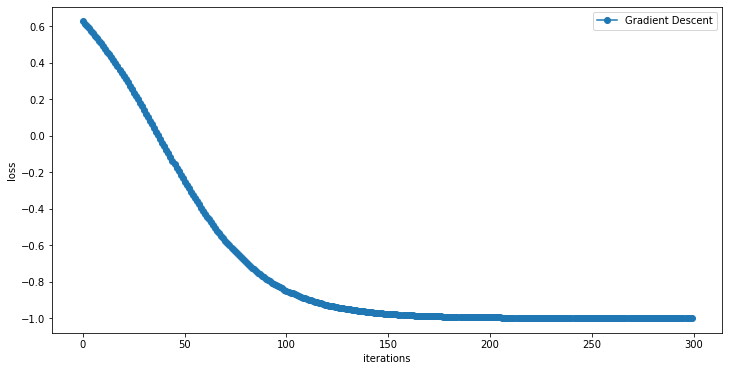

In [42]:
def plot_losses():

    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', marker='o', label='Gradient Descent')
    #plt.plot(qng_qnn_loss, 'tab:green', marker='o', label='natural gradients')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend(loc='best')

plot_losses()